If you do not understand pieces of code in this or files, please look here at the file titled angel_api.ipyb as i have gone more in depth with basic steps there.

This file is the first step in testing a simple strategy where we use daily data to predict if a stock is likely to rise, fall or stay stable tomorrow. This is without using any time series analysis, just simply, all indicators available in the pandas_TA library.

In [1]:
# package import statement
from smartapi import SmartConnect #or from smartapi.smartConnect import SmartConnect
#import smartapi.smartExceptions(for smartExceptions)

#create object of call
obj = SmartConnect(api_key="ef3Q6vdl")
                #optional
                #access_token = "your access token",
                #refresh_token = "your refresh_token")

#login api call

data = obj.generateSession(##user,##password)
refreshToken = data['data']['refreshToken']

#fetch the feedtoken
feedToken = obj.getfeedToken()

#fetch User Profile
userProfile = obj.getProfile(refreshToken)

In [2]:
import pandas as pd

all_symbols = pd.read_json("OpenAPIScripMaster.json")
all_symbols.head()

,token,symbol,name,expiry,strike,lotsize,instrumenttype,exch_seg,tick_size
0,22197,737JH31-SG,737JH31,,-1,100,,NSE,1
1,2372,63PY26-SG,63PY26,,-1,100,,NSE,1
2,9698,UTDGR31P12-MF,UTDGR31P12,,-1,1,,NSE,1
3,6022,ABSLAMC-BL,ABSLAMC,,-1,1,,NSE,5
4,20054,IIFCL-N2,IIFCL,,-1,1,,NSE,1


In [3]:
nifty200 = pd.read_csv('ind_nifty200list.csv')
train_symbols = list(nifty200['Symbol'] + '-EQ')

len(train_symbols)

200

In [4]:
nifty200 = pd.read_csv('ind_nifty200list.csv')
train_symbols = list(nifty200['Symbol'] + '-EQ')

nse_stocks = []
for i in range(len(train_symbols)):
    nse_stocks.append(all_symbols[(all_symbols.exch_seg == 'NSE') & (all_symbols['symbol'] == train_symbols[i])])

token = {}
for i in nse_stocks:
    try:
        t = (i['token'].values)[0]
        sym = (i['symbol'].values)[0]
        token[sym] = (t)
    except:
        pass


In [5]:
from datetime import date, timedelta

prev_D = str(date.today() - timedelta(days = 500)) + ' 09:00'
prev_D

'2021-04-06 09:00'

In [6]:
all_data_D = []
all_t = []
import time

for t in token.values():    
    #Historic api
    try:
        time.sleep(.25)
        historicParam={
            "exchange": "NSE",
            "symboltoken": str(t),
            "interval": "ONE_DAY",
            "fromdate": prev_D,
            "todate": "2022-08-15 17:15"
        }
        
        hist = obj.getCandleData(historicParam)
        
        #print(hist)
        if(len(hist['data']) >= 1): #used to be 1355
            all_t.append(t)
            all_data_D.append(hist['data'])
        

    except Exception as e:
        print("Historic Api failed: {}".format(e))
        print(len(all_data_D))

In [7]:
import numpy as np

for i in range(len(all_data_D)):
    all_data_D[i] = pd.DataFrame(all_data_D[i])

    real_names = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

    all_data_D[i].columns = real_names

    all_data_D[i]['timestamp'] = pd.to_datetime(all_data_D[i]['timestamp'])

    vals = list(token.values()).index(all_t[i])
    all_data_D[i]['stock'] = list(token.keys())[vals]
    

In [8]:
old_data = all_data_D.copy() #Just a backup

Minimum .5% change to be considered up or down and max .25% stoploss. Creating our target variable here.

In [9]:
for i in range(len(all_data_D)):
    #all_data_D[i].set_index(pd.DatetimeIndex(all_data_D[i]["timestamp"]), inplace=True)

    decision = []

    for j in range(len(all_data_D[i])):
        o = all_data_D[i].iloc[j]['open']
        h = all_data_D[i].iloc[j]['high']
        l = all_data_D[i].iloc[j]['low']
        c = all_data_D[i].iloc[j]['close']

        change_perc = ((c-o)/o) * 100
        buy_sl = ((o-l)/o) * 100
        sell_sl = ((h-o)/o) * 100
       
        if(buy_sl <= .25 and change_perc > .5):
            decision.append(1)
        elif(sell_sl <= .25 and change_perc < -.5):
            decision.append(-1)
        else:
            decision.append(0)

    all_data_D[i]['decision'] = decision


In [ ]:
all_dat = pd.concat(all_data_D)

In [ ]:
all_dat.tail()

,timestamp,open,high,low,close,volume,stock,decision
334,2022-08-05 00:00:00+05:30,244.50,247.05,241.35,243.85,5339714,ZEEL-EQ,0
335,2022-08-08 00:00:00+05:30,243.80,252.70,242.80,251.25,5303788,ZEEL-EQ,0
336,2022-08-10 00:00:00+05:30,252.00,254.30,247.10,249.90,5653775,ZEEL-EQ,0
337,2022-08-11 00:00:00+05:30,253.00,253.00,246.60,248.05,4886239,ZEEL-EQ,-1
338,2022-08-12 00:00:00+05:30,247.45,248.70,240.45,241.80,8136502,ZEEL-EQ,0


### Looking at the distribution of our target variable, decision

<AxesSubplot:xlabel='decision', ylabel='count'>

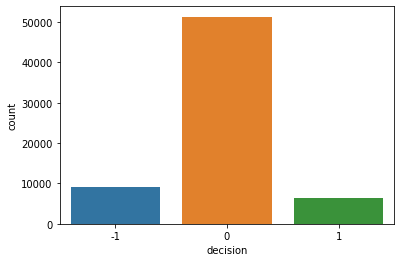

In [ ]:
import seaborn as sns

sns.countplot(x='decision', data=all_dat)

In [ ]:
all_data_D[0].head()

,timestamp,open,high,low,close,volume,stock,decision
0,2021-04-05 00:00:00+05:30,1908.0,1937.00,1872.10,1894.40,1271763,ACC-EQ,0
1,2021-04-06 00:00:00+05:30,1904.9,1922.70,1890.05,1908.45,965403,ACC-EQ,0
2,2021-04-07 00:00:00+05:30,1919.5,1954.50,1901.90,1918.45,1643312,ACC-EQ,0
3,2021-04-08 00:00:00+05:30,1925.0,2010.00,1924.00,1981.65,948225,ACC-EQ,1
4,2021-04-09 00:00:00+05:30,1999.0,2022.85,1948.45,1960.75,1376500,ACC-EQ,0


### List of all available indicators

In [ ]:
import pandas_ta as ta

all_indics = ['aberration', 'above', 'above_value', 'accbands', 'ad', 'adosc', 'adx', 'alma', 'amat', 'ao', 'aobv', 'apo', 'aroon', 'atr', 'bbands', 'below', 'below_value', 'bias', 'bop', 'brar', 'cci', 'cdl_pattern', 'cdl_z', 'cfo', 'cg', 'chop', 'cksp', 'cmf', 'cmo', 'coppock', 'cross', 'cross_value', 'cti', 'decay', 'decreasing', 'dema', 'dm', 'donchian', 'dpo', 'ebsw', 'efi', 'ema', 'entropy', 'eom', 'er', 'eri', 'fisher', 'fwma', 'ha', 'hilo', 'hl2', 'hlc3', 'hma', 'hwc', 'hwma', 'ichimoku', 'increasing', 'inertia', 'jma', 'kama', 'kc', 'kdj', 'kst', 'kurtosis', 'kvo', 'linreg', 'log_return', 'long_run', 'macd', 'mad', 'massi', 'mcgd', 'median', 'mfi', 'midpoint', 'midprice', 'mom', 'natr', 'nvi', 'obv', 'ohlc4', 'pdist', 'percent_return', 'pgo', 'ppo', 'psar', 'psl', 'pvi', 'pvo', 'pvol', 'pvr', 'pvt', 'pwma', 'qqe', 'qstick', 'quantile', 'rma', 'roc', 'rsi', 'rsx', 'rvgi', 'rvi', 'short_run', 'sinwma', 'skew', 'slope', 'sma', 'smi', 'squeeze', 'squeeze_pro', 'ssf', 'stc', 'stdev', 'stoch', 'stochrsi', 'supertrend', 'swma', 't3', 'td_seq', 'tema', 'thermo', 'tos_stdevall', 'trima', 'trix', 'true_range', 'tsi', 'tsignals', 'ttm_trend', 'ui', 'uo', 'variance', 'vhf', 'vidya', 'vortex', 'vp', 'vwap', 'vwma', 'wcp', 'willr', 'wma', 'xsignals', 'zlma', 'zscore','2crows', '3blackcrows', '3inside', '3linestrike', '3outside', '3starsinsouth', '3whitesoldiers', 'abandonedbaby', 'advanceblock', 'belthold', 'breakaway', 'closingmarubozu', 'concealbabyswall', 'counterattack', 'darkcloudcover', 'doji', 'dojistar', 'dragonflydoji', 'engulfing', 'eveningdojistar', 'eveningstar', 'gapsidesidewhite', 'gravestonedoji', 'hammer', 'hangingman', 'harami', 'haramicross', 'highwave', 'hikkake', 'hikkakemod', 'homingpigeon', 'identical3crows', 'inneck', 'inside', 'invertedhammer', 'kicking', 'kickingbylength', 'ladderbottom', 'longleggeddoji', 'longline', 'marubozu', 'matchinglow', 'mathold', 'morningdojistar', 'morningstar', 'onneck', 'piercing', 'rickshawman', 'risefall3methods', 'separatinglines', 'shootingstar', 'shortline', 'spinningtop', 'stalledpattern', 'sticksandwich', 'takuri', 'tasukigap', 'thrusting', 'tristar', 'unique3river', 'upsidegap2crows', 'xsidegap3methods']

### Adding all indicators as features to df and shifting to match with reality during inference

In [ ]:
for i in range(len(all_data_D)):
    for indic in all_indics:
        try:
            ta_func = getattr(all_data_D[i].ta, indic)
            all_data_D[i][indic] = ta_func()
        except:
            pass
    
    all_data_D[i].loc[:, ~all_data_D[i].columns.isin(['timestamp','decision','stock'])] = all_data_D[i].loc[:, ~all_data_D[i].columns.isin(['timestamp','decision','stock'])].shift(-1)
    all_data_D[i].dropna(inplace=True)
    
    #del all_data_D[i]['timestamp']
 

[X] Ooops!!! It's True, the series 'a' was not found in timestamp, open, high, low, close, volume, stock, decision
[X] Ooops!!! It's True, the series 'b' was not found in timestamp, open, high, low, close, volume, stock, decision
[X] Ooops!!! It's True, the series 'a' was not found in timestamp, open, high, low, close, volume, stock, decision
[X] value is not a number
[X] Ooops!!! It's True, the series 'b' was not found in timestamp, open, high, low, close, volume, stock, decision, ad, adosc, alma, ao, apo, atr
[X] value is not a number
[X] Please install TA-Lib to use 2crows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3blackcrows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3inside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3linestrike. (pip install TA-Lib)
[X] Please install TA-Lib to use 3outside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3starsinsouth. (pip install TA-Lib)
[X] Please install TA-Lib to use 3whitesoldiers. (pip install TA-

### Normalizing 

In [ ]:
all_means = []
for i in range(len(all_data_D)):
    #normalize columns
    try:
        per_stock = []

        for col in all_data_D[0].columns:
            if(col not in ['timestamp','stock','decision']):
                all_data_D[i][col] = (all_data_D[i][col] / max(all_data_D[i][col]))
                per_stock.append(all_data_D[i][col].mean())
        all_means.append(per_stock)
    except:
        print(all_data_D[i]['stock'][0])
        

### Saving dataset to csv

In [ ]:
all_dat = pd.concat(all_data_D)
all_dat.to_csv('all_data_indics.csv')